# GeoPython Week - exercise 2
## Table of Contents
- [Define interval](#interval)
- [Split: Train - Validation - Test](#split)
- [Pipeline](#pipeline)

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

import pickle
import os
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# create folder to save models
models_loc='models/'
if not os.path.exists(models_loc):
    os.makedirs(models_loc)

In [3]:
# define parameters
interval= True
WS_level=0.8
make_gridsearch=False
make_kfold=False
K_folds=5

In [4]:
# read data
#logs=pd.read_csv('data_cleaned1/logs_combined.csv')
logs = pd.read_csv("Data/logs_7wells.csv")
stack_logs=pd.read_csv('data/seismic_7wells.csv')
stack_section2=pd.read_csv('data/section_2D_2.csv')

logs['Target']=0
logs.loc[logs['Water Saturation']<=WS_level, 'Target']=1

In [5]:
seismic_att_names=['Time','AmpEnv', 'AppPolr', 'AWCP', 'AWF', 'Der',
       'DomF', 'InstF', 'Integrated', 'QuadrTrace', 'SecDer', 'SecDerInstAmpl', 
       'Seismic']

In [6]:
logs.describe()

,Time,Density,P_wave,Porosity,V_clay,Water Saturation,Imp,Target
count,75758.000000,75758.000000,75758.000000,75758.000000,75758.000000,75758.000000,75758.000000,75758.000000
mean,2231.724908,2.259806,2623.788348,0.131551,0.643055,0.993751,6058.714313,0.011722
std,792.450806,0.254068,625.932406,0.052663,0.139405,0.054622,2056.542731,0.107630
min,514.875700,1.254200,69.095500,0.000000,0.000000,0.001000,173.482041,0.000000
25%,1623.530175,2.085200,2170.043700,0.088200,0.613300,1.000000,4524.402431,0.000000
50%,2295.511500,2.258500,2485.396000,0.121300,0.667600,1.000000,5609.819003,0.000000
75%,2866.009375,2.481600,2997.033275,0.162700,0.717900,1.000000,7465.468304,0.000000
max,3693.633300,3.069000,6082.184100,0.573800,1.000000,1.000000,17780.676767,1.000000


<a id='interval'></a>
## Train algorithms on small interwal 

 . |6507/3-6 | 6507/6-4A | 6507/5-5 | 6507/3-9S | 6507/2-4 | 6507/2-2 | 6507/2-1
 ---|---|---|---|---|---|---|---				
from| 1300| 1050| 2585| 2650| 2670| 2666| 2674
to| 1352| 1200| 2734| 2800 |2800 |2800 |2840

In [7]:
# select df only in this intervals

if interval==True:

    sub_logs=logs[(logs['log_ID']=='6507_3-6') & (logs['Time']>=1300) & (logs['Time']<=1352)].append(
        logs[(logs['log_ID']=='6507_6-4A') & (logs['Time']>=1050) & (logs['Time']<=1200)]).append(
        logs[(logs['log_ID']=='6507_5-5') & (logs['Time']>=2585) & (logs['Time']<=2734)]).append(
        logs[(logs['log_ID']=='6507_3-9s') & (logs['Time']>=2650) & (logs['Time']<=2800)]).append(
        logs[(logs['log_ID']=='6507_2-4') & (logs['Time']>=2670) & (logs['Time']<=2800)]).append(
        logs[(logs['log_ID']=='6507_2-2') & (logs['Time']>=2666) & (logs['Time']<=2800)]).append(
        logs[(logs['log_ID']=='6507_2-1') & (logs['Time']>=2674) & (logs['Time']<=2840)]).reset_index(drop=True)
    
else:
    # select df only in this intervals

    sub_logs=logs[(logs['Horison']=='2D-K65') | (logs['Horison']=='2D-BCU')| 
         (logs['Horison']=='2D-bottom')| (logs['Horison'].isna())]

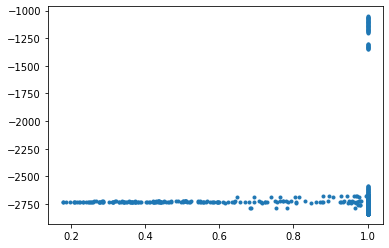

In [8]:
plt.plot(sub_logs['Water Saturation'],-sub_logs['Time'],  '.')

In [9]:
(sub_logs['Water Saturation']<0.9).sum(), sub_logs.shape[0]

(174, 4006)

2 additional well on proposed intervals don't have oil (Water Saturation==1). log'6507_5-5' has oil on 3230 up to 3266

In [10]:
logs[(logs['log_ID']=='6507_5-5') & (logs['Water Saturation']<1.0)]

,Time,Density,P_wave,Porosity,V_clay,Water Saturation,log_ID,Horison,Imp,Target
75158,3230.0,2.6212,86.1755,0.0860,0.7564,0.9974,6507_5-5,NaN,225.883221,0
75159,3234.0,2.3672,79.2598,0.1682,0.0545,0.0815,6507_5-5,NaN,187.623799,1
75160,3238.0,2.3693,75.4672,0.1604,0.0602,0.0448,6507_5-5,NaN,178.804437,1
75161,3242.0,2.3687,75.4699,0.1601,0.0652,0.0504,6507_5-5,NaN,178.765552,1
75162,3246.0,2.4287,71.4300,0.1256,0.0670,0.1406,6507_5-5,NaN,173.482041,1
75163,3250.0,2.4472,71.0303,0.1153,0.0696,0.2849,6507_5-5,NaN,173.825350,1
75164,3254.0,2.3816,77.9391,0.1602,0.0745,0.2734,6507_5-5,NaN,185.619761,1
75165,3258.0,2.3854,77.4561,0.1585,0.0620,0.2992,6507_5-5,NaN,184.763781,1
75166,3262.0,2.4949,76.2368,0.0853,0.3599,0.9099,6507_5-5,NaN,190.203192,0
75167,3266.0,2.6242,71.8005,0.0526,0.3944,0.9964,6507_5-5,NaN,188.418872,0


### Moving average

In [11]:
#stack_logs[stack_logs['log_ID']=='6507_2-1'][['Time', 'Stack']]
def opposite_mov_avg(data):
    
    data_1=(data+data.shift(1))/2
    data_1=data.append(data_1.dropna()).sort_values('Time').reset_index(drop=True)
    data_2=(data_1+data_1.shift(1))/2
    data_2=data_1.append(data_2.dropna()).sort_values('Time').reset_index(drop=True)
    return data_2

stack_logs_extra_points=opposite_mov_avg(stack_logs[stack_logs['log_ID']=='6507_2-1'][['Time', 'Seismic']])

In [12]:
count=0
stack_logs_extra_points=[]
for log_id in stack_logs['log_ID'].value_counts().index.to_list():
    
    df_extra_points=opposite_mov_avg(stack_logs[stack_logs['log_ID']==log_id][['Time', 'Seismic']])
    df_extra_points['log_ID']=log_id
    
    if count==0:
        stack_logs_extra_points=df_extra_points
    else:
        stack_logs_extra_points=stack_logs_extra_points.append(df_extra_points)
    
    count=count+1

In [13]:
mov_avg=False
if mov_avg==True:
    sub_logs['Time_rounded']=np.round(sub_logs['Time']/1)*1
    sub_logs=sub_logs.groupby(['log_ID','Time_rounded']).mean().reset_index().drop('Time', axis=1).rename(columns={'Time_rounded': 'Time'})
    sub_logs['Target']=0
    sub_logs.loc[sub_logs['Water Saturation']<=0.95, 'Target']=1
    
    sub_logs=pd.merge(sub_logs,stack_logs_extra_points, how='inner', on=['log_ID','Time']).sort_values(['log_ID','Time'])
    
    features=[ 'Density', 'P_wave', 'Porosity',  'Imp', 'Seismic'] #'V_clay',
else: 
    features=[ 'Density', 'P_wave', 'Porosity',  'Imp']#,'V_clay']

<a id='split'></a>
## Split data into Train - Validation - Test
Test - one well

In [14]:
test_df=sub_logs[sub_logs['log_ID']=='6507_2-4']
train_df=sub_logs[~(sub_logs['log_ID']=='6507_2-4')]

In [15]:
train_df['log_ID'].value_counts()

6507_2-1     1529
6507_2-2     1156
6507_5-5       38
6507_6-4A      38
6507_3-6       13
Name: log_ID, dtype: int64

In [16]:
test_df['log_ID'].value_counts()

6507_2-4    1232
Name: log_ID, dtype: int64

In [17]:
sub_logs.columns

Index(['Time', 'Density', 'P_wave', 'Porosity', 'V_clay', 'Water Saturation',
       'log_ID', 'Horison', 'Imp', 'Target'],
      dtype='object')

In [18]:
features=['Density', 'P_wave', 'Porosity', 'Imp']

In [19]:
X=train_df[features]
Y=train_df['Target']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

X_test=test_df[features]
y_test=test_df['Target']

In [20]:
# find numerical and catoegorical column names
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
print (numerical_ix)
print (categorical_ix)

Index(['Density', 'P_wave', 'Porosity', 'Imp'], dtype='object')
Index([], dtype='object')


### Functions for visializing the results

In [21]:
def prec_recall_report(y_true, y_pred):
    
    prec, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, average='binary')    
        
    print ('Precision: ', prec)
    print ('Recall: ', recall)
    print ('F-score: ', fscore)

In [22]:
def f1_score_eval(y_true, y_pred):
    prec, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, average='binary') 
    return fscore

In [23]:
def prec_recall_fscore_train_val_test(clf, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train_pred=clf.predict(X_train)
    y_val_pred=clf.predict(X_val)
    y_test_pred=clf.predict(X_test)

    print ('Precision/ Recall/ F-score on train set : \n')
    prec_recall_report(y_train, y_train_pred)

    if (X_train.shape!=X_val.shape) or ~(X_train==X_val).all().all():
        print ('\n Precision/ Recall/ F-score on validation set : \n')
        prec_recall_report(y_val, y_val_pred)

    print ('\n Precision/ Recall/ F-score on test set : \n')
    prec_recall_report(y_test, y_test_pred)

    
    return y_train_pred, y_val_pred, y_test_pred

In [24]:
def real_predicted(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, title_text, logs=train_df, logs_4=test_df):
    fig, ax = plt.subplots(1,3,figsize=(15,8))


    #plot y_train Vs y_train_pred 
    ax[0].plot(y_train,-logs.loc[X_train.index.to_list()]['Time'], 'b.' , alpha=0.5)
    ax[0].plot(y_train_pred+0.015,-logs.loc[y_train.index.to_list()]['Time'], 'r.' , alpha=0.5)
    ax[0].legend(['original', 'predicted']);
    ax[0].set_xlabel('1-oil / 0-otherwise');
    ax[0].set_ylabel('Time');
    ax[0].set_title('train set'); 
    
    ax[1].plot(y_val,-logs.loc[X_val.index.to_list()]['Time'], 'b.' , alpha=0.5)
    ax[1].plot(y_val_pred+0.015,-logs.loc[y_val.index.to_list()]['Time'], 'r.' , alpha=0.5)
    ax[1].legend(['original', 'predicted']);
    ax[1].set_xlabel('1-oil / 0-otherwise');
    ax[1].set_ylabel('Time');
    ax[1].set_title('validation set'); 

    #plot y_test VS y_test_pred
    ax[2].plot(y_test,-logs_4['Time'], 'b.' , alpha=0.5)
    ax[2].plot(y_test_pred+0.015,-logs_4['Time'], 'r.' , alpha=0.5)
    ax[2].legend(['original', 'predicted']);
    ax[2].set_title('test set');    
    ax[2].set_xlabel('1-oil / 0-otherwise');
    
    fig.suptitle(title_text, fontsize=16)

In [25]:
def predict_section(df1, method_name, method, features=features):
    df1['Pred']=method.predict(df1[features])

    df2=df1[['Trace','Time', 'Pred']].groupby(['Time', 'Trace'])['Pred'].aggregate('first').unstack()
    plt.figure(figsize=(20, 10))
    plt.title (method_name)
    ax = sb.heatmap(df2,vmin=0, vmax=1, cmap="YlGnBu")

In [26]:
def output_function(clf, clf_name, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train_pred, y_val_pred, y_test_pred=prec_recall_fscore_train_val_test(clf, 
                                                                        X_train, y_train, 
                                                                        X_val, y_val, 
                                                                        X_test, y_test)
    
    real_predicted(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, clf_name)
    predict_section(stack_section2.dropna(), '2D section1 - '+clf_name ,  clf )
        



In [27]:
def grid_search_function(clf, parameters, X_train, y_train):
    
    cv = GridSearchCV(clf,  param_grid=parameters, scoring = 'f1')
    cv.fit(X_train, y_train)
    print (cv.best_params_)
    
    return cv


In [28]:
def kfold_gridsearch_function(clf, parameters, X, Y, K_folds):
    
    cv= RepeatedStratifiedKFold(n_splits=K_folds, n_repeats=3, random_state=1)
    search = GridSearchCV(clf, parameters, scoring='f1', n_jobs=-1, cv=cv)
    result = search.fit(X, Y)
    print('Best Hyperparameters: %s' % result.best_params_, '\n')
    print('Mean test score: %s' % result.best_score_, '\n')
    print('Std test score: %s' % result.cv_results_['std_test_score'][result.cv_results_['rank_test_score']==1].tolist()[0], '\n')
    
    return result

<a id='pipeline'></a>
## Build pipeline

### Columns transformation

In [29]:
# categorical columns -> One Hot Encoding 
# numerical column -> Scaling
t = [('cat', OneHotEncoder(drop='first'), categorical_ix), 
     ('num',StandardScaler(), numerical_ix)]

col_transform = ColumnTransformer(transformers=t)

## Define algorithms and hyper parameters

In [30]:
# Logistic regression
log_reg = Pipeline([
    ('prep',col_transform), 
    ('clf', LogisticRegression(random_state=42))
    ])

log_reg_params = {
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'clf__penalty':['l2', 'l1'],
        'clf__C':[100, 10, 1.0, 0.1, 0.01]
    }
## ------------------------------------------------------------------
# Gaussian Naive Bayes 
gnb = Pipeline([
    ('prep',col_transform), 
    ('clf', GaussianNB())
    ])

gnb_params= {
        'clf__var_smoothing': [0.00000001, 0.000000001, 0.00000001]
    }
## ------------------------------------------------------------------
# Support Vector Machine
svm=Pipeline([
    ('prep',col_transform), 
    ('clf', SVC(random_state=42))
    ])

svm_params = {
        'clf__kernel':['poly', 'rbf', 'sigmoid'],
        'clf__gamma': ['scale'],
        'clf__C':[50, 10, 1.0, 0.1, 0.01]
    }
## ------------------------------------------------------------------
# Gradient boodting classifier
gbc=Pipeline([
    ('prep',col_transform), 
    ('clf', GradientBoostingClassifier(random_state=42))
    ])

gbc_params = {
        'clf__n_estimators': [10, 100, 1000],
        'clf__learning_rate': [0.001, 0.01, 0.1],
        'clf__subsample':[0.5, 0.7, 1.0], 
        'clf__max_depth': [3, 7, 9]
    }
## ------------------------------------------------------------------
# Multi-layer Perceptron classifier
mlpc= Pipeline([
    ('prep',col_transform), 
    ('clf', MLPClassifier(random_state=1))
     ])

mlpc_params = {
        'clf__hidden_layer_sizes': [(10,30,10),(20,)],
        'clf__activation': ['tanh', 'relu'],
        'clf__solver': ['sgd', 'adam'],
        'clf__alpha': [0.0001, 0.05],
        'clf__learning_rate': ['constant','adaptive']
    }

## 1 Logistic regression 

### 1.1 No parameters tuning

In [31]:
log_reg.fit(X_train, y_train);

Precision/ Recall/ F-score on train set : 

Precision:  0.0
Recall:  0.0
F-score:  0.0

 Precision/ Recall/ F-score on validation set : 

Precision:  0.0
Recall:  0.0
F-score:  0.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.20353982300884957
F-score:  0.3382352941176471


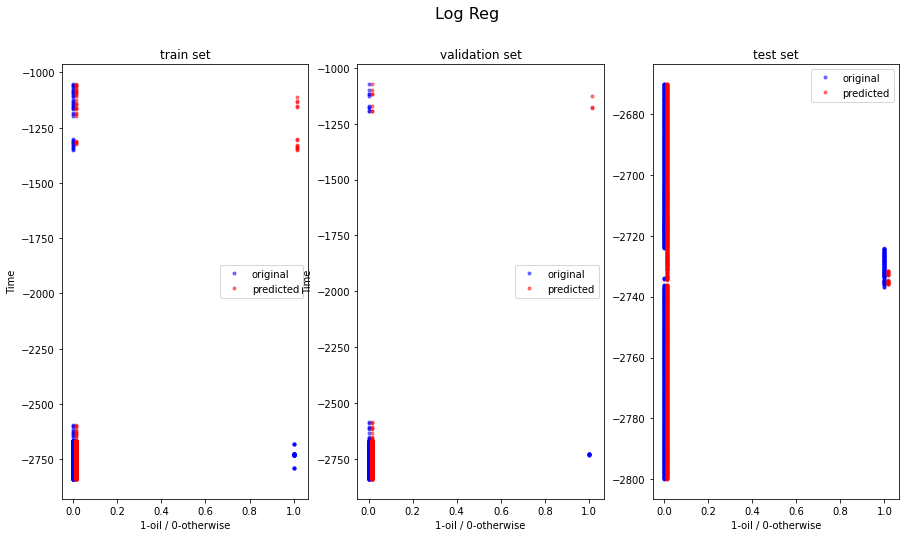

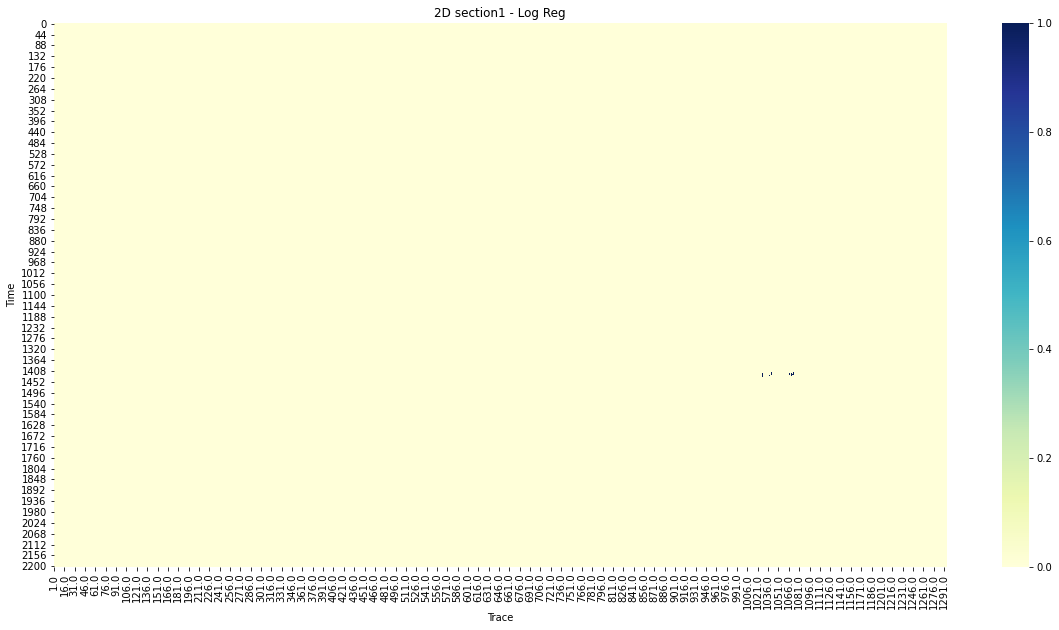

In [32]:
output_function(log_reg, 'Log Reg', X_train, y_train, X_val, y_val, X_test, y_test)

### 1.2 Grid Search for Hyperparameters tuning on Train / Validation / Test (Logistic regression) 

{'clf__C': 100, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Precision/ Recall/ F-score on train set : 

Precision:  0.7352941176470589
Recall:  0.6578947368421053
F-score:  0.6944444444444445

 Precision/ Recall/ F-score on validation set : 

Precision:  0.8888888888888888
Recall:  0.8
F-score:  0.8421052631578948

 Precision/ Recall/ F-score on test set : 

Precision:  0.8677685950413223
Recall:  0.9292035398230089
F-score:  0.8974358974358975


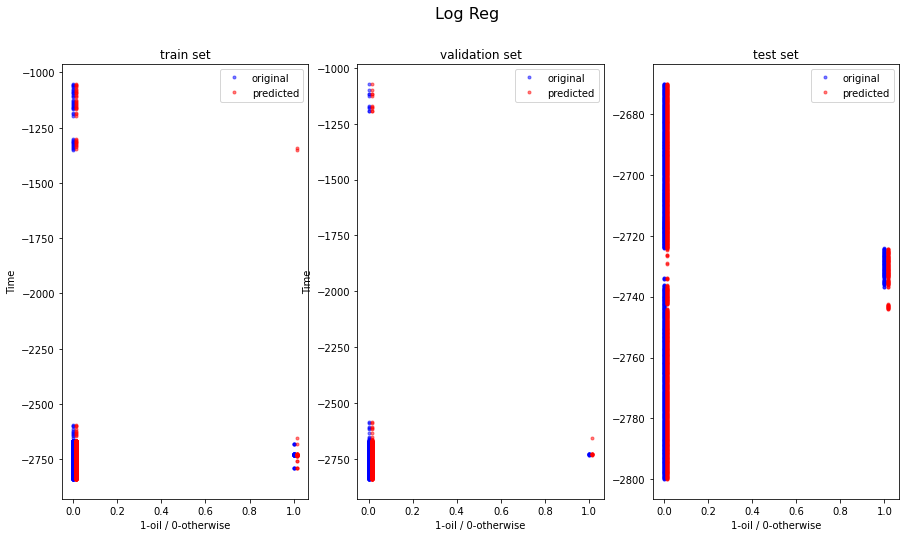

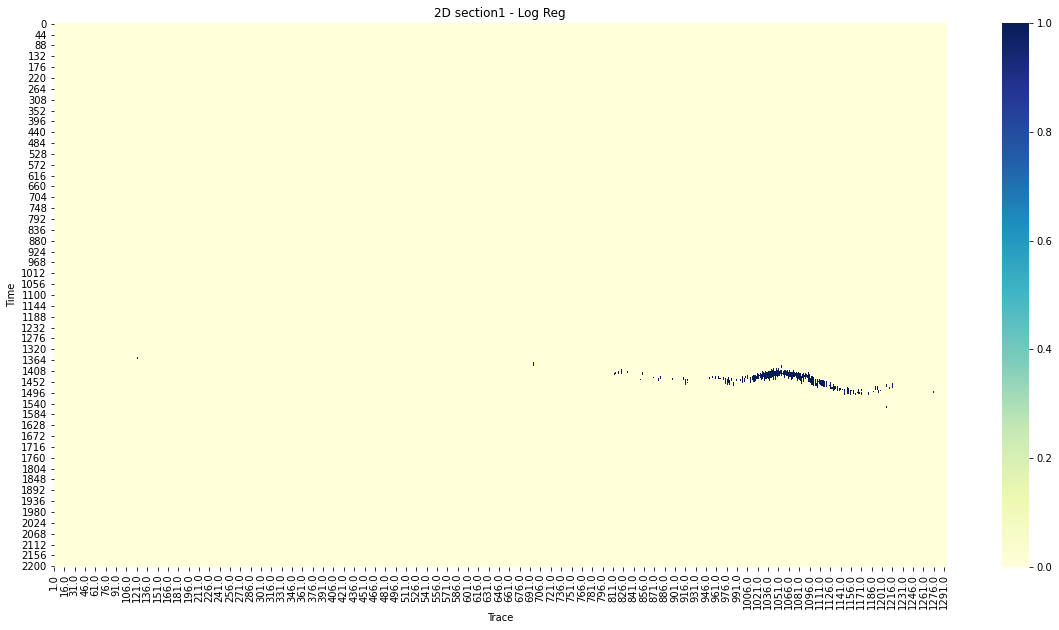

In [33]:
make_gridsearch1=True
if make_gridsearch1==True:
    cv=grid_search_function(log_reg, log_reg_params, X_train, y_train)
    output_function(cv, 'Log Reg', X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'log_reg_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

### 1.3 KFold and Grid Search (Logistic Regression)

Best Hyperparameters: {'clf__C': 100, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'} 

Mean test score: 0.6715196452341426 

Std test score: 0.10998142601852216 

Precision/ Recall/ F-score on train set : 

Precision:  0.7272727272727273
Recall:  0.6666666666666666
F-score:  0.6956521739130435

 Precision/ Recall/ F-score on test set : 

Precision:  0.865546218487395
Recall:  0.911504424778761
F-score:  0.8879310344827587


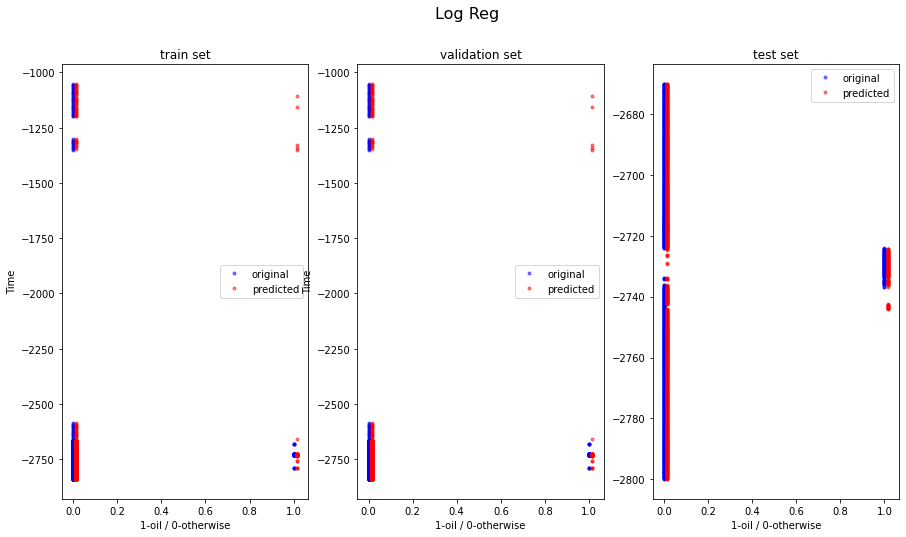

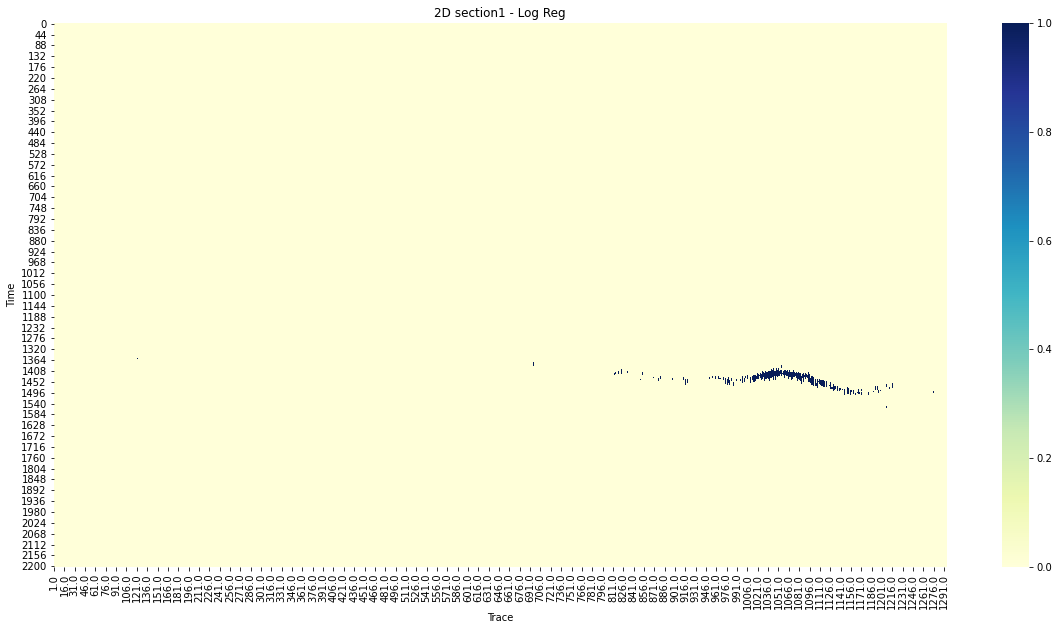

In [34]:
make_kfold1=True
if make_kfold1==True:
    result=kfold_gridsearch_function(log_reg, log_reg_params, X, Y, K_folds)
    output_function(result, 'Log Reg', X, Y, X, Y, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'log_reg_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

## 2. Gaussian Naive Bayes

### 2.1 No parameters tuning

Precision/ Recall/ F-score on train set : 

Precision:  0.5
Recall:  0.8157894736842105
F-score:  0.62

 Precision/ Recall/ F-score on validation set : 

Precision:  0.47368421052631576
Recall:  0.9
F-score:  0.6206896551724138

 Precision/ Recall/ F-score on test set : 

Precision:  0.9230769230769231
Recall:  0.6371681415929203
F-score:  0.7539267015706808


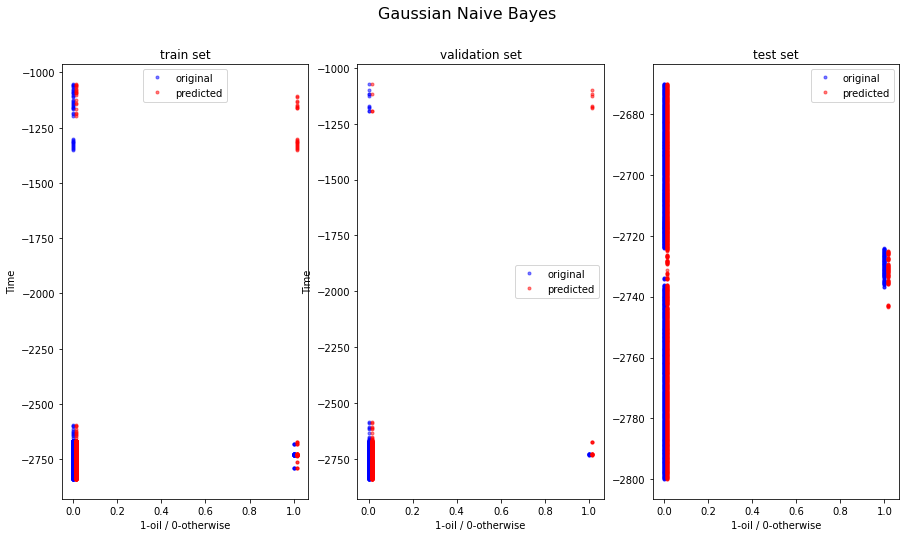

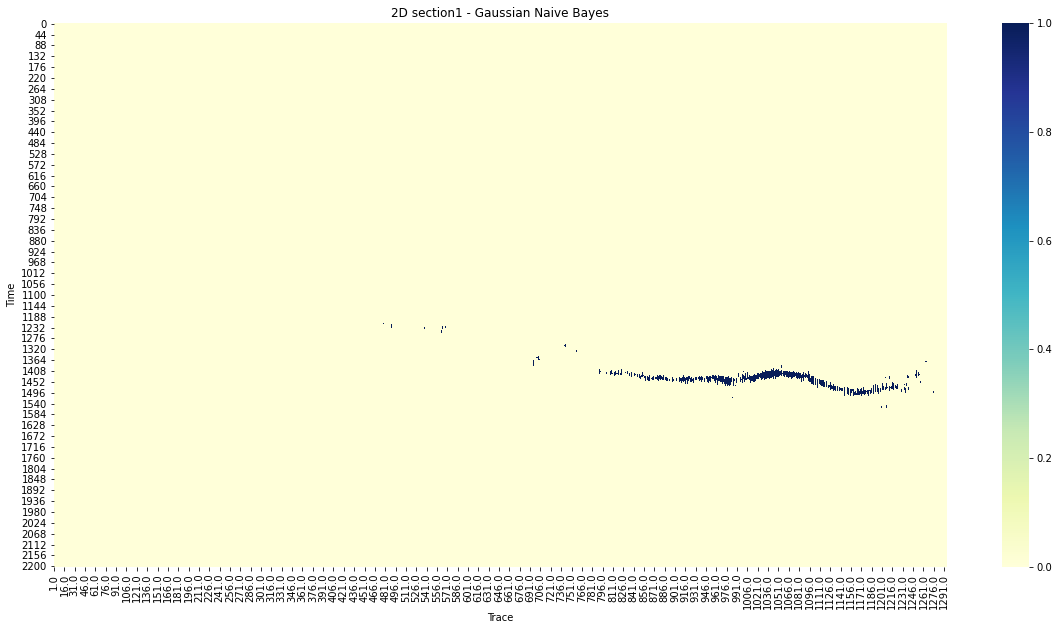

In [35]:
gnb.fit(X_train, y_train)
output_function(gnb, 'Gaussian Naive Bayes', X_train, y_train, X_val, y_val, X_test, y_test)

### 2.2 Grid search for Gaussian Naive Bayes hyperparams on Train/ Validation / Test

In [36]:
if make_gridsearch==True:
    cv=grid_search_function(gnb, gnb_params,X_train, y_train)
    output_function(cv, 'Gaussian Naive Bayes', X_train, y_train, X_val, y_val, X_test, y_test)
    
    #save model to file
    filename = 'gnb_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

### 2.3 Kfold+GridSEarch (Gaussian Naive Bayes)

In [37]:
if make_kfold==True:
    result=kfold_gridsearch_function(gnb, gnb_params, X, Y, K_folds)
    output_function(result, 'Gaussian Naive Bayes', X, Y, X, Y, X_test, y_test)
    
    #save model to file
    filename = 'gnb_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

## 3. Support Vector Machine

### 3.1 No parameters tuning

Precision/ Recall/ F-score on train set : 

Precision:  0.84375
Recall:  0.7105263157894737
F-score:  0.7714285714285714

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  0.9
F-score:  0.9473684210526316

 Precision/ Recall/ F-score on test set : 

Precision:  0.896551724137931
Recall:  0.6902654867256637
F-score:  0.7799999999999999


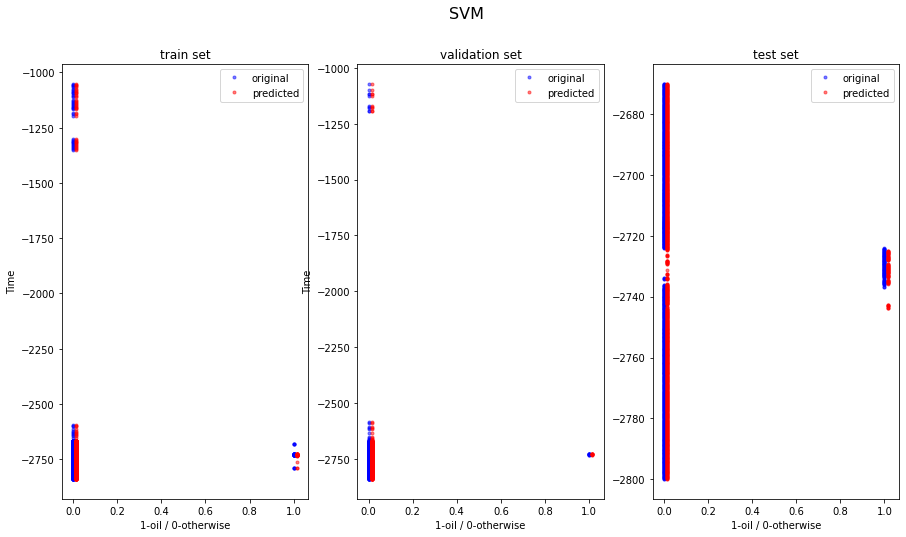

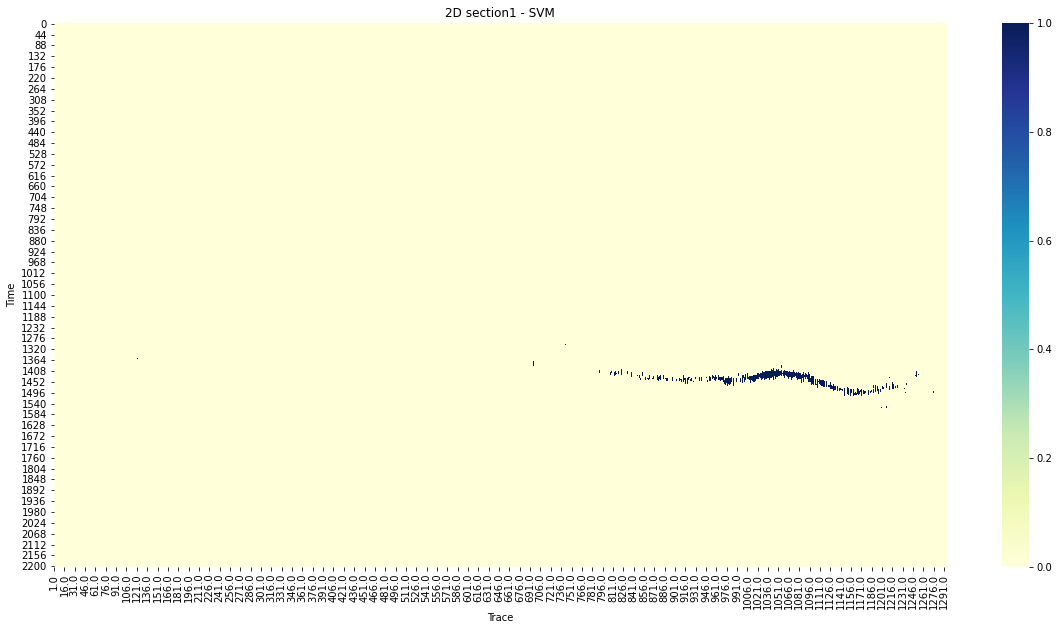

In [38]:
svm.fit(X_train, y_train)
output_function(svm, 'SVM', X_train, y_train, X_val, y_val, X_test, y_test)

### 3.2 Grid search SVM (Train/Validation/Test)

In [39]:
if make_gridsearch==True:
    cv=grid_search_function(svm, svm_params, X_train, y_train)
    output_function(cv, 'SVM', X_train, y_train, X_val, y_val, X_test, y_test)
    
    #save model to file
    filename = 'svm_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

### 3.3. Kfold + GridSearch on SVM

In [40]:
if make_kfold==True:
    result=kfold_gridsearch_function(svm, svm_params, X, Y, K_folds)
    output_function(result, 'SVM', X, Y, X, Y, X_test, y_test)
    
    #save model to file
    filename = 'svm_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

## 4. Gradient Boosting clf

### 4.1 No parameters tuning

Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  0.8
F-score:  0.888888888888889

 Precision/ Recall/ F-score on test set : 

Precision:  0.9404761904761905
Recall:  0.6991150442477876
F-score:  0.802030456852792


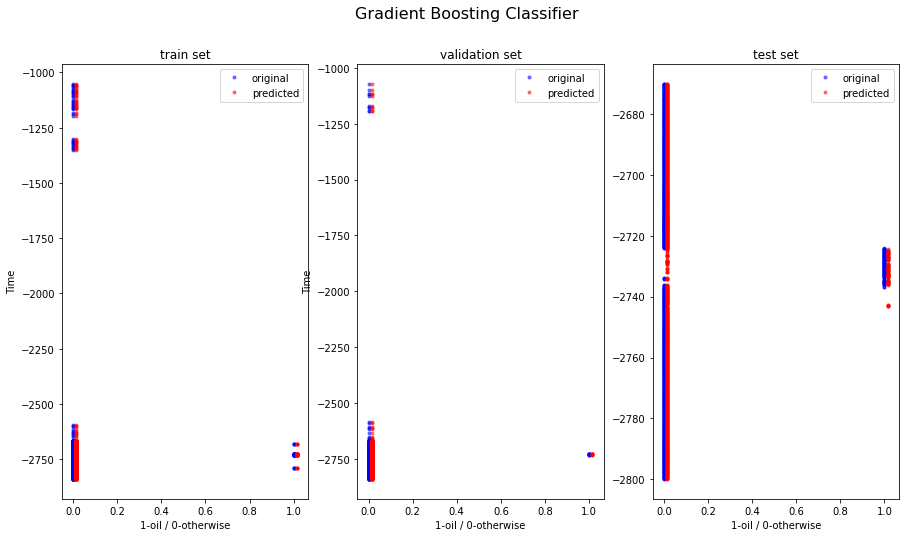

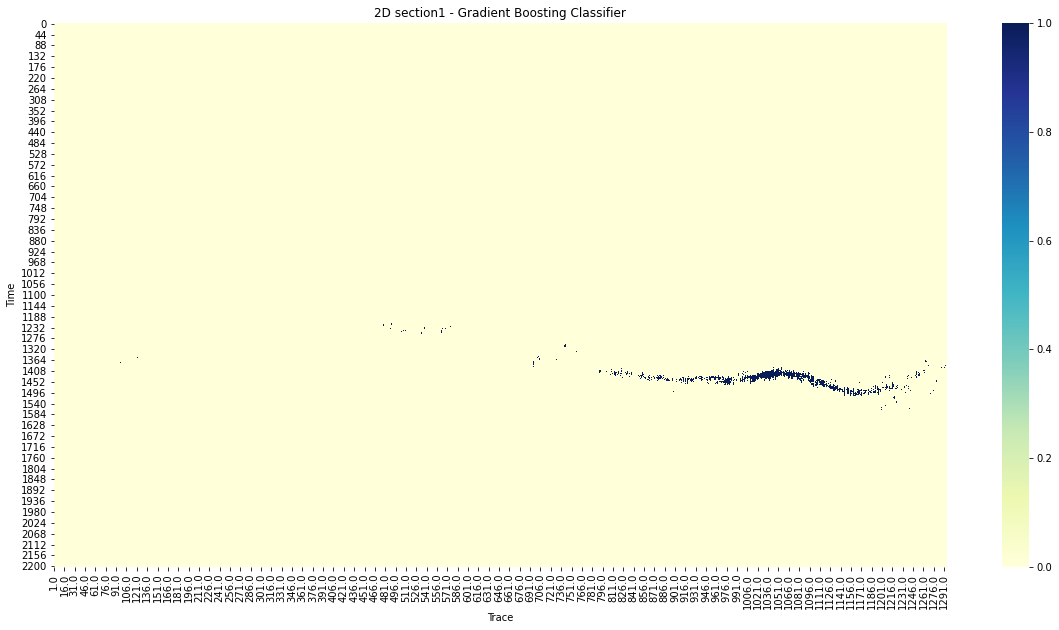

In [41]:
gbc.fit(X_train, y_train)
output_function(gbc, 'Gradient Boosting Classifier', X_train, y_train, X_val, y_val, X_test, y_test)

### 4.2 Grid Search for Gradient Boosting clf (Train/Validation/Test)

In [42]:
if make_gridsearch==True:
    cv=grid_search_function(gbc, gbc_params, X_train, y_train)
    output_function(cv, 'Gradient Boosting Classifier', X_train, y_train, X_val, y_val, X_test, y_test)
    
    #save model to file
    filename = 'gbc_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

### 4.3 Kfold + Grid Search (  Gradient Boosting Classifier)

In [43]:
if make_kfold==True:
    result=kfold_gridsearch_function(gbc, gbc_params, X, Y, K_folds)
    output_function(result, 'Gradient Boosting Classifier', X, Y, X, Y, X_test, y_test)
    
    #save model to file
    filename = 'gbc_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

## 5. MLPClassifier (Neural Network)

### 5.1 No parameters tuning

In [44]:
mlpc.fit(X_train, y_train);

Precision/ Recall/ F-score on train set : 

Precision:  0.8378378378378378
Recall:  0.8157894736842105
F-score:  0.8266666666666665

 Precision/ Recall/ F-score on validation set : 

Precision:  0.9
Recall:  0.9
F-score:  0.9

 Precision/ Recall/ F-score on test set : 

Precision:  0.88
Recall:  0.7787610619469026
F-score:  0.8262910798122066


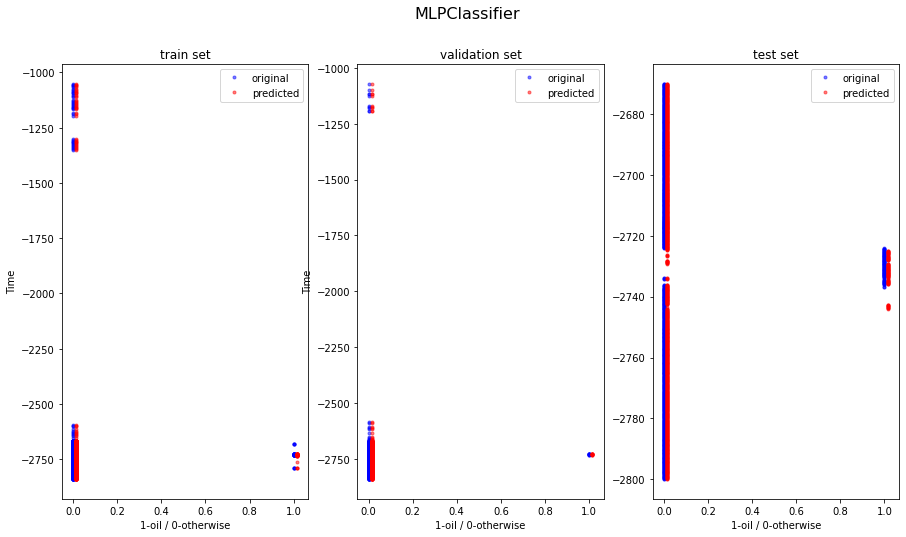

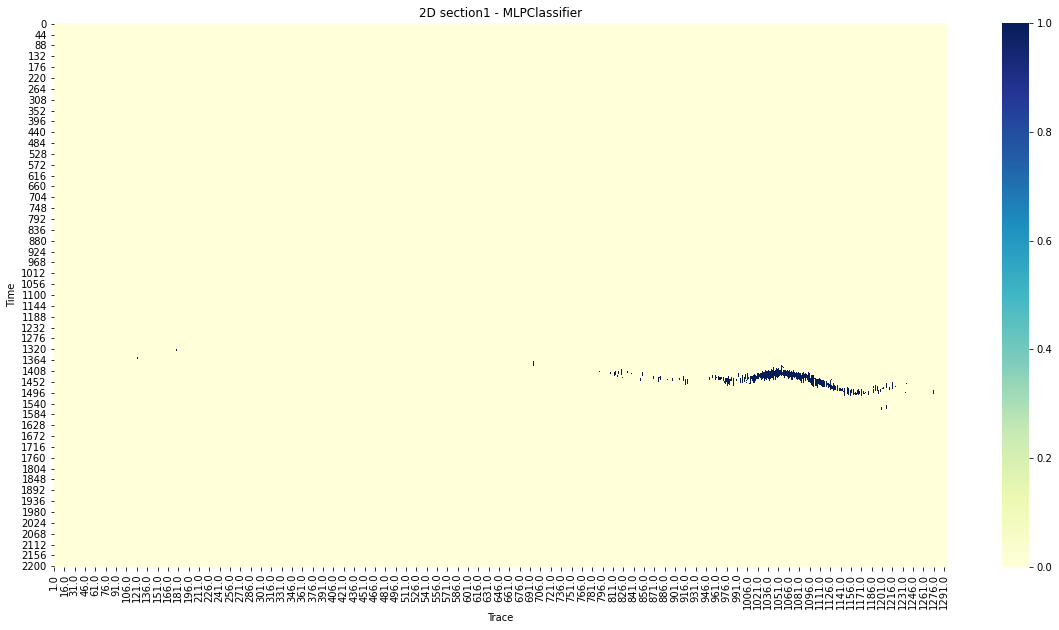

In [45]:
output_function(mlpc, 'MLPClassifier', X_train, y_train, X_val, y_val, X_test, y_test)

### 5.2 Grid Search MLPC (Train/ Validation/ test)

In [46]:
if make_gridsearch==True:
    cv=grid_search_function(mlpc, mlpc_params, X_train, y_train)
    output_function(cv, 'MLPClassifier', X_train, y_train, X_val, y_val, X_test, y_test)

    #save model to file
    filename = 'mlpc_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

### 5.3 Kfold + Grid Search (MLP classifier)

In [47]:

if make_kfold==True:
    result=kfold_gridsearch_function(mlpc, mlpc_params, X, Y, K_folds)
    output_function(result, 'MLPClassifier', X, Y, X, Y, X_test, y_test)
    
    #save model to file
    filename = 'mlpc_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))